In [1]:
import qiime2 as q2
import pandas as pd
import numpy as np
import skbio
import os
import biom

import scipy.stats as ss
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from qiime2.plugins import diversity, feature_table, gemelli

In [2]:
data_dir = '../Updated_Data/RF_Data/LIBR_Data/'
data_dict_16s = {
    'ANX_OR_MDD': biom.load_table(data_dir + 'Amp_MDD_OR_ANX_uncollapsed.biom'),
    'ANX': biom.load_table(data_dir + 'Amp_ANX_uncollapsed.biom'),
    'ANX_ONLY': biom.load_table(data_dir + 'Amp_ANX_ONLY_uncollapsed.biom'),
    'MDD': biom.load_table(data_dir + 'Amp_MDD_uncollapsed.biom'),
    'MDD_ONLY': biom.load_table(data_dir + 'Amp_MDD_ONLY_uncollapsed.biom'), 
    'ANX_AND_MDD': biom.load_table(data_dir + 'Amp_MDD_AND_ANX_uncollapsed.biom')
}

gg2_tree = q2.Artifact.load('../Updated_Data/2022.10.phylogeny.asv.nwk.qza')
metadata = pd.read_csv(data_dir + 'metadata.tsv', sep='\t', index_col=0)

In [3]:
metadata.loc[metadata.index.intersection(data_dict_16s['ANX'].ids())]['DX_ANX'].value_counts()

True     332
False    164
Name: DX_ANX, dtype: int64

In [8]:
unmedicated_ids = pd.read_csv('../Updated_Data/Medications_Data/unmedicated_metadata.tsv', 
                              sep='\t', index_col=0).index
medicated_ids = metadata.index.difference(unmedicated_ids)
unmedicated_table_ids = unmedicated_ids.intersection(data_dict_16s['ANX_OR_MDD'].ids())
medicated_table_ids = medicated_ids.intersection(data_dict_16s['ANX_OR_MDD'].ids())
data_dict_16s['Unmedicated'] = data_dict_16s['ANX_OR_MDD'].filter(unmedicated_table_ids, inplace=False)
data_dict_16s['Medicated'] = data_dict_16s['ANX_OR_MDD'].filter(medicated_table_ids, inplace=False)

In [7]:
for distance_metric in ['uwuf', 'wuf', 'rpca']: 
    table = q2.Artifact.import_data('FeatureTable[Frequency]', data_dict_16s['ANX_OR_MDD'])
    rare = feature_table.methods.rarefy(table=table, sampling_depth=5000).rarefied_table
    if distance_metric == 'rpca': 
        gemelli_out = gemelli.methods.rpca(table=table)
        biplot = gemelli_out.biplot
        dm = gemelli_out.distance_matrix
    elif distance_metric == 'uwuf':
        dm = diversity.pipelines.beta_phylogenetic(table=rare, phylogeny=gg2_tree, 
                                                   metric='unweighted_unifrac').distance_matrix
    elif distance_metric == 'wuf': 
        dm = diversity.pipelines.beta_phylogenetic(table=rare, phylogeny=gg2_tree, 
                                                   metric='weighted_unifrac').distance_matrix
    
    if distance_metric in ['uwuf', 'wuf']: 
        pcoa = diversity.methods.pcoa(distance_matrix = dm, number_of_dimensions=3).pcoa
        rel_freq = feature_table.methods.relative_frequency(table=table).relative_frequency_table
        biplot = diversity.methods.pcoa_biplot(pcoa=pcoa, features=rel_freq).biplot
    
    dm.save(distance_metric + '_distance_matrix.qza') 
    biplot.save(distance_metric + '_biplot.qza')

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/9120a1e0-9fcb-460e-ae0b-884d9c80a24c/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk -m unweighted -o /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-xq16roma

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/461e4034-8fe5-4b1f-bcfd-d42c606ca344/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz988000

/Volumes/GoogleDrive/My Drive/U19/Tulsa_MultiOmics/Updated_Data/RF_Data/LIBR_Data/gemelli/gemelli/preprocessing.py:420: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


In [9]:
def get_biplot(distance_metric, phylogeny=None): 
    dm = q2.Artifact.load(distance_metric + '_distance_matrix.qza') 
    biplot = q2.Artifact.load(distance_metric + '_biplot.qza')
    return dm.view(skbio.DistanceMatrix), biplot.view(skbio.OrdinationResults)

In [10]:
def make_pcoa(bt, md, column, xpos=0, ypos=0, phylogeny=None, distance_metric='rpca', title='RPCA Ordination', 
              custom_labels=None, custom_title='Diagnosis'): 
    dm, biplot = get_biplot(distance_metric, phylogeny)
    
    md = md.loc[md.index.intersection(bt.ids())]
    ordination = biplot.samples.merge(md[[column]], right_index=True, left_index=True)
 
    sns.scatterplot(data=ordination, x=0, y=1, hue=column)
    pc2_prop = str(np.round(biplot.proportion_explained[1]*100, 2))
    pc1_prop = str(np.round(biplot.proportion_explained[0]*100, 2))
    plt.ylabel('PC2 (' + pc2_prop + '%)')
    plt.xlabel('PC1 (' + pc1_prop + '%)')
    plt.title(title)
    
    dm = dm.filter(bt.ids())
    perm_out = skbio.stats.distance.permanova(dm, md, column)
    f_stat = str(np.round(perm_out['test statistic'], 3))
    p_val = str(perm_out['p-value'])
    
    if custom_labels is not None: 
        ax = plt.gca()
        handles, labels = ax.get_legend_handles_labels()
        plt.legend(loc='upper left', bbox_to_anchor=(1.04, 1), handles=handles[:2], labels=custom_labels, 
                   title=custom_title)
    else: 
        plt.legend(loc='upper left', bbox_to_anchor=(1.04, 1), title=custom_title)
    plt.text(xpos, ypos, 'F=' + f_stat + ', p=' + p_val, size=14)
    plt.show()

In [11]:
def calculate_permanova(bt, md, column, phylogeny=None, metrics=['rpca', 'uwuf', 'wuf']):
    out_df = pd.DataFrame(columns=['pseudo_f', 'p_value'], index=metrics)
    for m in metrics:
        dm, _ = get_biplot(m, phylogeny)
        dm = dm.filter(bt.ids())
        perm_out = skbio.stats.distance.permanova(dm, md, column)
        out_df['pseudo_f'][m] = np.round(perm_out['test statistic'], 3)
        out_df['p_value'][m] = perm_out['p-value']
    return out_df

In [12]:
def calculate_perm_across_groups(bt_dict, md, phylogeny, permanova_col): 
    list_of_perm_res = []
    
    for k in bt_dict: 
        perm_res = calculate_permanova(bt_dict[k], md, permanova_col, phylogeny=phylogeny).reset_index()
        perm_res.rename(columns={'index': 'metric'}, inplace=True)
        perm_res['comparison'] = k
        list_of_perm_res.append(perm_res)
    
    return pd.concat(list_of_perm_res)

In [13]:
def perm_across_cols(bt, md, columns, phylogeny=None, metrics=['rpca', 'uwuf', 'wuf']): 
    list_of_res = []
    for c in columns: 
        perm_df = calculate_permanova(bt, md, c, phylogeny)
        perm_df = perm_df.reset_index() 
        perm_df.rename(columns={'index': 'metric'}, inplace=True)
        perm_df['column'] = c
        list_of_res.append(perm_df)
    return pd.concat(list_of_res)

In [14]:
full_results = perm_across_cols(data_dict_16s['ANX_OR_MDD'], metadata, ['Medicated', 'Gender', 'DX_MDD', 'DX_ANX', 
                                                                        'N06A_Antidepressants', 'N05B_Anxiolytics', 
                                                                        'cobre'], gg2_tree)
unmedicated_results = perm_across_cols(data_dict_16s['Unmedicated'], metadata, 
                                       ['Gender', 'DX_MDD', 'DX_ANX', 'cobre'], gg2_tree)
medicated_results = perm_across_cols(data_dict_16s['Medicated'], metadata, ['Gender', 'DX_MDD', 'DX_ANX', 
                                                                            'N06A_Antidepressants',
                                                                            'N05B_Anxiolytics', 'cobre'], 
                                     gg2_tree)

(0.0, 20.0)

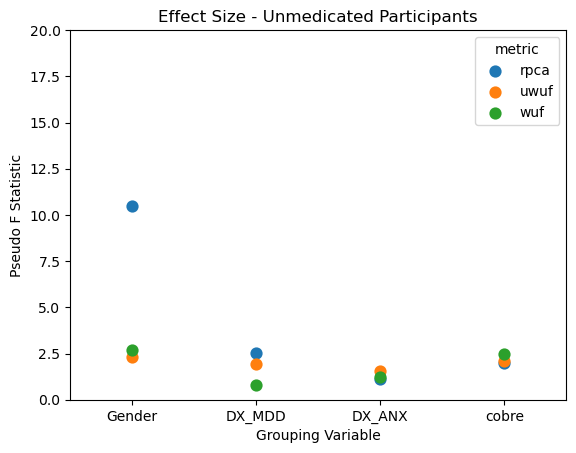

In [15]:
sns.pointplot(data=unmedicated_results, x='column', y='pseudo_f', hue='metric', 
              join=False)
plt.xlabel('Grouping Variable')
plt.ylabel('Pseudo F Statistic')
plt.title('Effect Size - Unmedicated Participants')
plt.ylim(0, 20)

(0.0, 20.0)

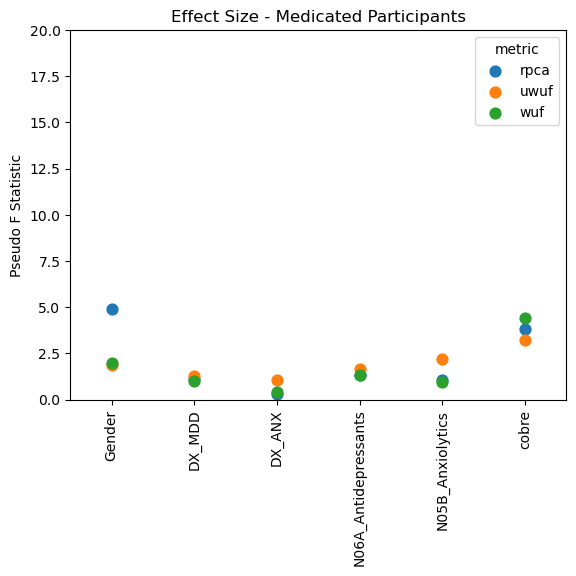

In [16]:
sns.pointplot(data=medicated_results, x='column', y='pseudo_f', hue='metric', join=False)
plt.xlabel('')
plt.ylabel('Pseudo F Statistic')
plt.title('Effect Size - Medicated Participants')
plt.xticks(rotation=90)
plt.ylim(0, 20)

In [17]:
from matplotlib.gridspec import GridSpec

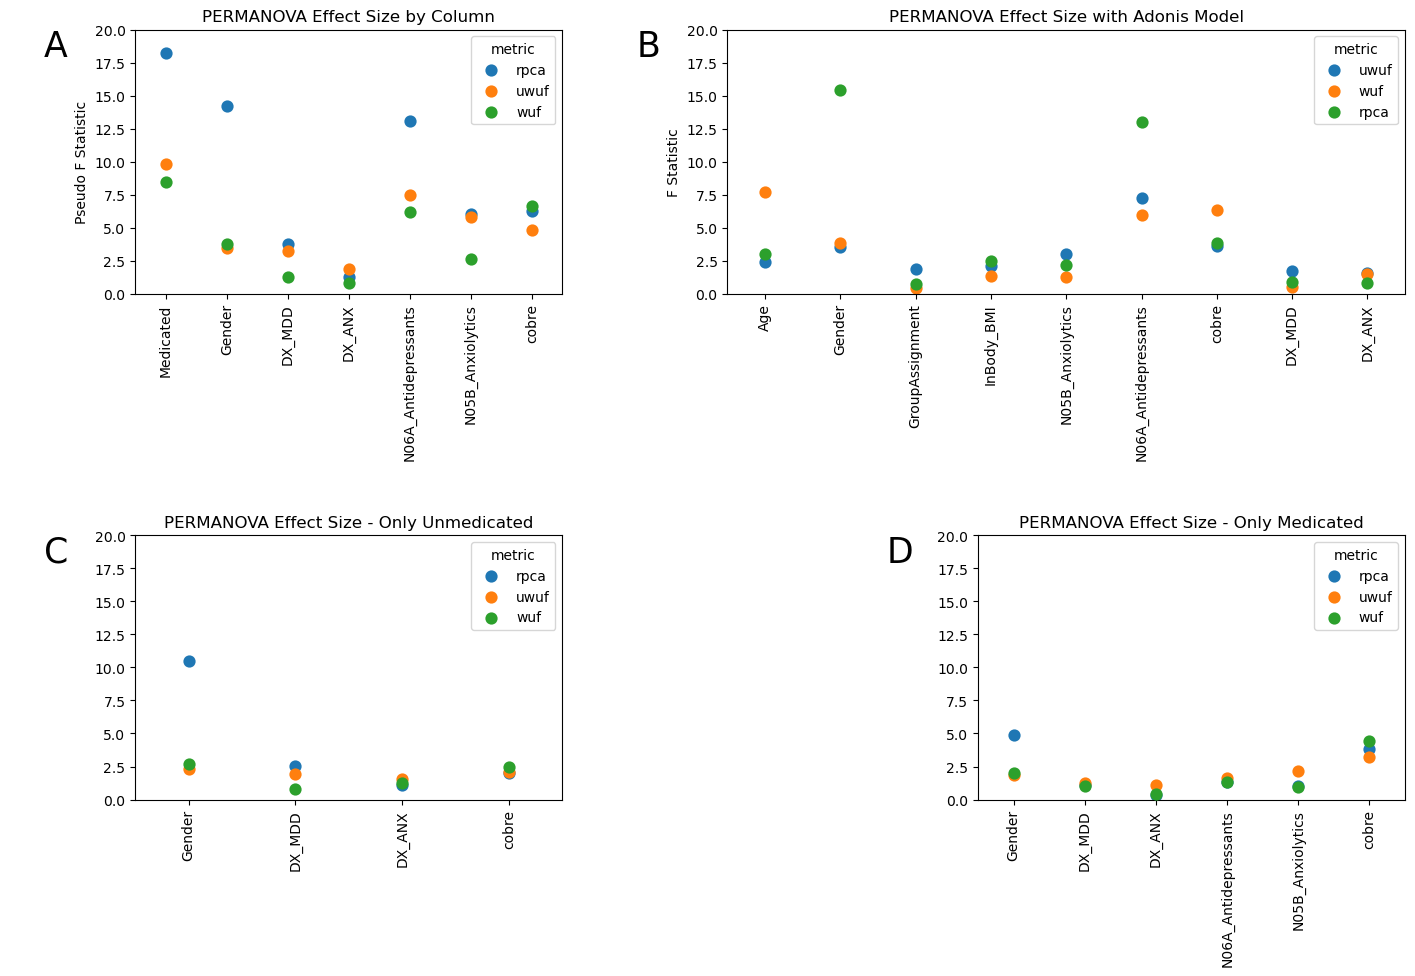

In [36]:
fig = plt.figure(figsize=(18, 10))
gs = GridSpec(nrows=3, ncols=6, wspace=0.2, width_ratios=[1, 5, 1, 1, 1, 5], height_ratios=[7, 4, 7])

ax00 = fig.add_subplot(gs[0, 0])
ax00.annotate('A', xy = (0.4, 0.9), fontsize=25)
ax00.grid(False)
ax00.axis('off')

ax01 = fig.add_subplot(gs[0, 1])
sns.pointplot(data=full_results, x='column', y='pseudo_f', hue='metric', join=False, ax=ax01)
ax01.set_xlabel('')
ax01.set_ylabel('Pseudo F Statistic')
ax01.set_title('PERMANOVA Effect Size by Column')
ax01.set_ylim(0, 20)
for tick in ax01.get_xticklabels():
    tick.set_rotation(90)

ax02 = fig.add_subplot(gs[0, 2])
ax02.annotate('B', xy = (0.4, 0.9), fontsize=25)
ax02.grid(False)
ax02.axis('off')

ax03 = fig.add_subplot(gs[0, 3:])
sns.pointplot(data=all_results, x='variable', y='F_stat', hue='metric', join=False, ax=ax03)
ax03.set_ylabel('F Statistic')
ax03.set_xlabel('')
ax03.set_ylim(0, 20)
ax03.set_title('PERMANOVA Effect Size with Adonis Model')
for tick in ax03.get_xticklabels():
    tick.set_rotation(90)


ax10 = fig.add_subplot(gs[2, 0])
ax10.annotate('C', xy = (0.4, 0.9), fontsize=25)
ax10.grid(False)
ax10.axis('off')

ax11 = fig.add_subplot(gs[2, 1])
sns.pointplot(data=unmedicated_results, x='column', y='pseudo_f', hue='metric', 
              join=False, ax=ax11)
ax11.set_xlabel('')
ax11.set_ylabel('')
ax11.set_title('PERMANOVA Effect Size - Only Unmedicated')
ax11.set_ylim(0, 20)
for tick in ax11.get_xticklabels():
    tick.set_rotation(90)

ax14 = fig.add_subplot(gs[2, 4])
ax14.annotate('D', xy = (0.4, 0.9), fontsize=25)
ax14.grid(False)
ax14.axis('off')

ax13 = fig.add_subplot(gs[2, 5])
sns.pointplot(data=medicated_results, x='column', y='pseudo_f', hue='metric', join=False, 
              ax=ax13)
ax13.set_xlabel('')
ax13.set_ylabel('')
ax13.set_title('PERMANOVA Effect Size - Only Medicated')
ax13.set_ylim(0, 20)
for tick in ax13.get_xticklabels():
    tick.set_rotation(90)

In [4]:
import adonis

In [5]:
md_q2 = q2.Metadata.load(data_dir+'metadata.tsv')
dms = {
    'uwuf': q2.Artifact.load('uwuf_distance_matrix.qza'), 
    'wuf': q2.Artifact.load('wuf_distance_matrix.qza'),
    'rpca': q2.Artifact.load('rpca_distance_matrix.qza')
}

In [6]:
all_res = []
for dm in dms: 
    for var in ['GroupAssignment', 'DX_MDD', 'DX_ANX']: 
        model = "N06A_Antidepressants+N05B_Anxiolytics+Age+Gender+cobre+InBody_BMI+" + var
        adonis_out = adonis.adonis_and_reformat(dms[dm], md_q2, model, 'adonis_out')
        adonis_out['metric'] = dm
        all_res.append(adonis_out)
all_results = pd.concat(all_res)

R version 4.2.2 (2022-10-31) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.2 (2022-10-31) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.2 (2022-10-31) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.2 (2022-10-31) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.2 (2022-10-31) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.2 (2022-10-31) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.2 (2022-10-31) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.2 (2022-10-31) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


R version 4.2.2 (2022-10-31) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


Text(0.5, 1.0, 'Effect Sizes by Variable')

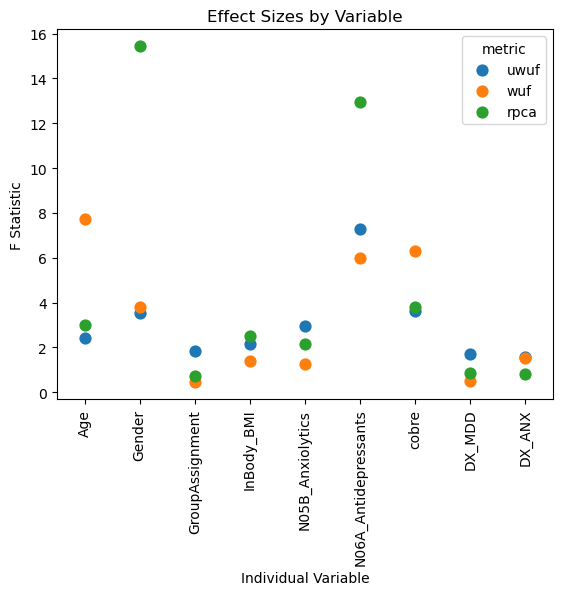

In [7]:
sns.pointplot(data=all_results, x='variable', y='F_stat', hue='metric', join=False)
plt.xticks(rotation=90)
plt.ylabel('F Statistic')
plt.xlabel('Individual Variable')
plt.title('Effect Sizes by Variable')

In [37]:
all_results.sort_values(by='F_stat', ascending=False)

,F_stat,partial_R2,pval,formula,variable,metric
2,16.060894,0.022159,0.001,N06A_Antidepressants+N05B_Anxiolytics+Age+Gend...,Gender,rpca
2,16.058011,0.022159,0.001,N06A_Antidepressants+N05B_Anxiolytics+Age+Gend...,Gender,rpca
1,16.055908,0.022159,0.001,N06A_Antidepressants+N05B_Anxiolytics+Age+Gend...,Gender,rpca
5,13.143268,0.018134,0.001,N06A_Antidepressants+N05B_Anxiolytics+Age+Gend...,N06A_Antidepressants,rpca
5,13.140909,0.018134,0.001,N06A_Antidepressants+N05B_Anxiolytics+Age+Gend...,N06A_Antidepressants,rpca
...,...,...,...,...,...,...
1,1.113897,0.001537,0.316,N06A_Antidepressants+N05B_Anxiolytics+Age+Gend...,DX_ANX,rpca
1,0.991103,0.001368,0.38,N06A_Antidepressants+N05B_Anxiolytics+Age+Gend...,DX_MDD,rpca
2,0.90152,0.001244,0.4,N06A_Antidepressants+N05B_Anxiolytics+Age+Gend...,GroupAssignment,rpca
1,0.636667,0.000896,0.643,N06A_Antidepressants+N05B_Anxiolytics+Age+Gend...,DX_MDD,wuf


In [161]:
adonis.adonis_and_reformat(uwuf_dm, md_q2, "Medicated+Gender+Age+GroupAssignment", 'adonis_out')

R version 4.2.2 (2022-10-31) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


,F_stat,partial_R2,pval,formula,variable
0,3.25543,0.004744,0.001,Medicated+Gender+Age+GroupAssignment,Age
1,3.844518,0.005602,0.001,Medicated+Gender+Age+GroupAssignment,Gender
2,1.492647,0.002175,0.107,Medicated+Gender+Age+GroupAssignment,GroupAssignment
3,13.682348,0.019937,0.001,Medicated+Gender+Age+GroupAssignment,Medicated


In [157]:
adonis.adonis_and_reformat(wuf_dm, md_q2, "Medicated+Gender+Age+GroupAssignment", 'adonis_out')

R version 4.2.2 (2022-10-31) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


,F_stat,partial_R2,pval,formula,variable
0,1.370058,0.002027,0.209,Medicated+Gender+GroupAssignment,Gender
1,0.804671,0.00119,0.439,Medicated+Gender+GroupAssignment,GroupAssignment
2,8.829616,0.013061,0.001,Medicated+Gender+GroupAssignment,Medicated


In [158]:
adonis.adonis_and_reformat(rpca_dm, md_q2, "Medicated+Gender+GroupAssignment", 'adonis_out')

R version 4.2.2 (2022-10-31) 


Loading required package: permute
Loading required package: lattice
This is vegan 2.6-4


,F_stat,partial_R2,pval,formula,variable
0,6.987411,0.010105,0.001,Medicated+Gender+GroupAssignment,Gender
1,0.780163,0.001128,0.484,Medicated+Gender+GroupAssignment,GroupAssignment
2,18.678975,0.027014,0.001,Medicated+Gender+GroupAssignment,Medicated


In [112]:
calculate_permanova(data_dict_16s['ANX_OR_MDD'], metadata, 'Gender', gg2_tree)

,pseudo_f,p_value
rpca,7.036,0.001
uwuf,3.929,0.002
wuf,1.376,0.218


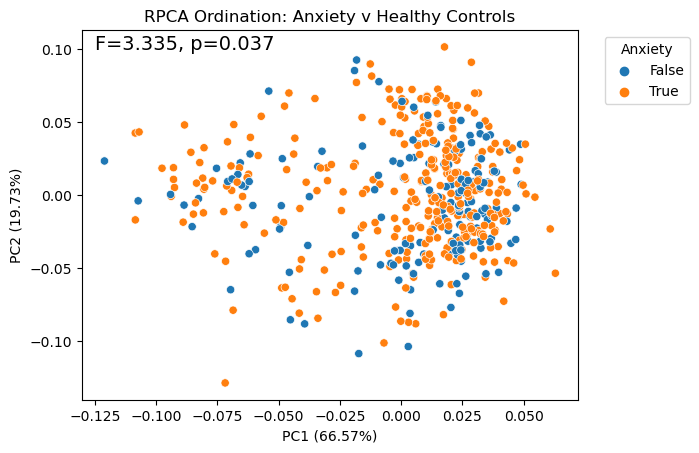

In [11]:
make_pcoa(data_dict_16s['ANX'], metadata, 'DX_ANX', xpos=-0.125, ypos=0.1, 
          title='RPCA Ordination: Anxiety v Healthy Controls', custom_title='Anxiety')

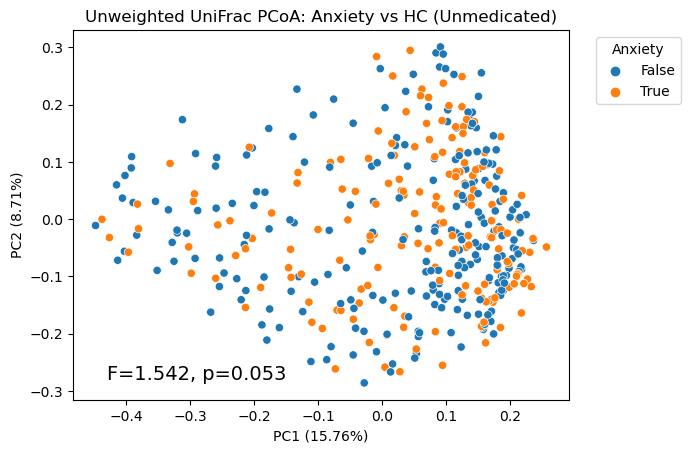

In [19]:
make_pcoa(data_dict_16s['Unmedicated'], metadata, 'DX_ANX', xpos=-0.43, ypos=-0.28, distance_metric='uwuf', 
          title='Unweighted UniFrac PCoA: Anxiety vs HC (Unmedicated)', custom_title='Anxiety')

In [15]:
metadata['N05B_Anxiolytics']

,anonymized_name,antibiotic_indication,antibiotic_type,antibiotics_last_6_mo,any_health_condition_that_may_affect_microbiome,any_health_condition_that_may_affect_microbiome_describe,appendix_removed,born_by_csection,change_in_weight_5lbs_30_days,chronic_migraines,...,C10_LipidReducingAgents,J01_Antibacterials,N05_Psycholeptics,N06_Psychoanaleptics,N05A_Antipsychotics,N05B_Anxiolytics,N05C_Hypnotics_and_Sedatives,N06A_Antidepressants,N06B_Psychostimulants_for_ADHD_and_Nootropics,N06D_AntiDementia_drugs
SampleID,,,,,,,,,,,,,,,,,,,,,
10424.AI557.F,AI557.F,not applicable,not applicable,no,no,none,no,no,no,no,...,False,False,False,False,False,False,False,False,False,False
10424.AI107.F,AI107.F,not applicable,not applicable,no,no,not applicable,no,no,yes,no,...,False,False,False,True,False,False,False,False,True,False
10424.AF544.F,AF544.F,not applicable,not applicable,no,no,not applicable,no,no,no,no,...,False,False,False,True,False,False,False,True,False,False
10424.AI898.F,AI898.F,not applicable,not applicable,no,no,not applicable,yes,no,yes,no,...,False,False,False,True,False,False,False,True,False,False
10424.AJ148.F,AJ148.F,not applicable,not applicable,no,no,not applicable,no,yes,no,no,...,False,False,True,True,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10424.AX394.f,AX394.f,NaN,NaN,No,NaN,NaN,No,No,No,Yes,...,False,False,False,False,False,False,False,False,False,False
10424.AZ670.f,AZ670.f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
10424.AZ690.f,AZ690.f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False


In [36]:
metadata.groupby('cobre')['InBody_BMI'].mean()

cobre
No     28.152724
Yes    26.527152
Name: InBody_BMI, dtype: float64

In [32]:
metadata.loc[metadata.cobre == 'Yes']

,anonymized_name,antibiotic_indication,antibiotic_type,antibiotics_last_6_mo,any_health_condition_that_may_affect_microbiome,any_health_condition_that_may_affect_microbiome_describe,appendix_removed,born_by_csection,change_in_weight_5lbs_30_days,chronic_migraines,...,DX_ED,DX_HC,DX_MDD,DX_Other,DX_PTSD,DX_SUD,Gender,GroupAssignment,InBody_BMI,Medicated
SampleID,,,,,,,,,,,,,,,,,,,,,
10424.AA343.F.N,AA343.F.N,Yeast Infection,I don't remember,Yes,NaN,NaN,No,Yes,No,No,...,False,False,True,False,False,False,Female,Mood/Anxiety,31.2,Un-medicated
10424.AB546.F.N,AB546.F.N,NaN,NaN,No,none,NaN,No,No,No,No,...,False,True,False,False,False,False,Female,Healthy Control,27.5,Un-medicated
10424.AE085.F.N,AE085.F.N,NaN,NaN,No,NaN,NaN,No,No,No,No,...,False,False,True,False,False,False,Female,Mood/Anxiety,20.5,Medicated
10424.AL627.F.1year,AL627.F.1year,NaN,NaN,No,NaN,NaN,No,No,No,No,...,False,False,True,False,False,False,Male,Mood/Anxiety,31.5,Un-medicated
10424.AL808.F.1year,AL808.F.1year,possible sinus infection,amoxicillin,Yes,NaN,NaN,No,No,No,No,...,False,False,True,False,False,False,Female,Mood/Anxiety,24.6,Un-medicated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10424.bd464.F.N,bd464.F.N,NaN,NaN,No,none,NaN,No,No,No,No,...,False,False,True,False,True,False,Female,Mood/Anxiety,22.8,Un-medicated
10424.bh100.F.N,bh100.F.N,NaN,NaN,No,IBS triggered by certain foods,NaN,No,No,No,No,...,False,False,True,False,False,False,Female,Mood/Anxiety,19.5,Un-medicated
10424.bh806.F.N,bh806.F.N,NaN,NaN,No,NaN,NaN,No,No,No,No,...,False,True,False,False,False,False,Female,Healthy Control,22.2,Un-medicated


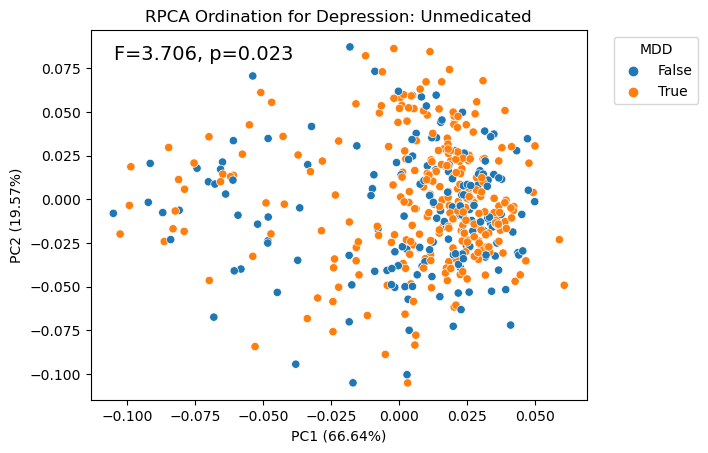

In [67]:
make_pcoa(data_dict_16s['Unmedicated'], metadata, 'DX_MDD', xpos=-0.105, ypos=0.08, 
          title='RPCA Ordination for Depression: Unmedicated', custom_title='MDD')

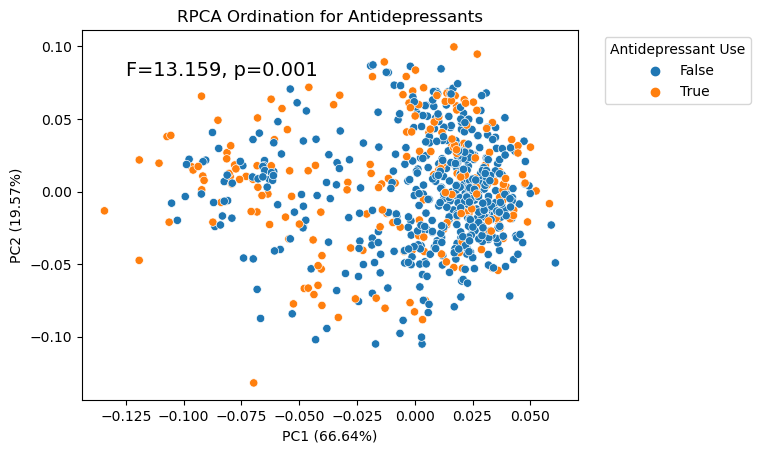

In [76]:
make_pcoa(data_dict_16s['ANX_OR_MDD'], metadata, 'N06A_Antidepressants', xpos=-0.125, ypos=0.08, 
          title='RPCA Ordination for Antidepressants', custom_title='Antidepressant Use')

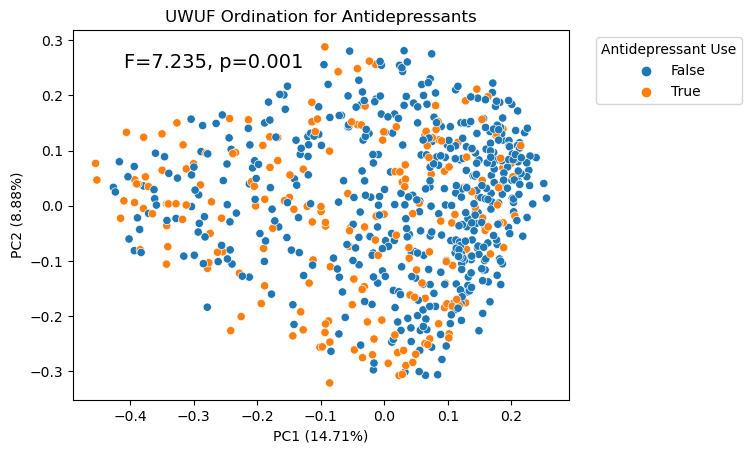

In [80]:
make_pcoa(data_dict_16s['ANX_OR_MDD'], metadata, 'N06A_Antidepressants', xpos=-0.41, ypos=0.25, 
          title='UWUF Ordination for Antidepressants', custom_title='Antidepressant Use', distance_metric='uwuf')

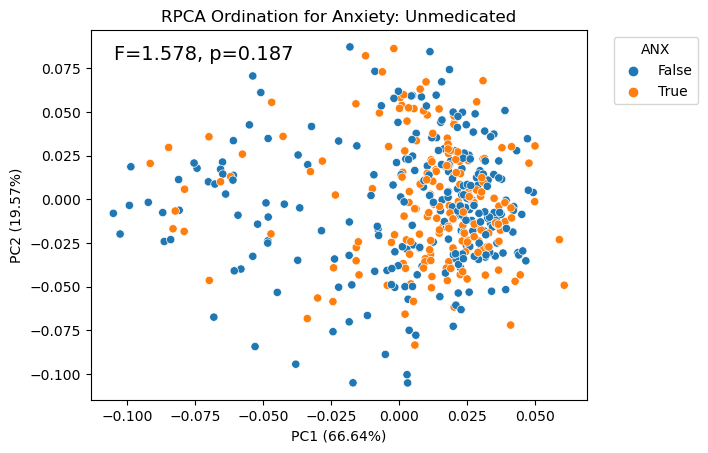

In [68]:
make_pcoa(data_dict_16s['Unmedicated'], metadata, 'DX_ANX', xpos=-0.105, ypos=0.08, 
          title='RPCA Ordination for Anxiety: Unmedicated', custom_title='ANX')

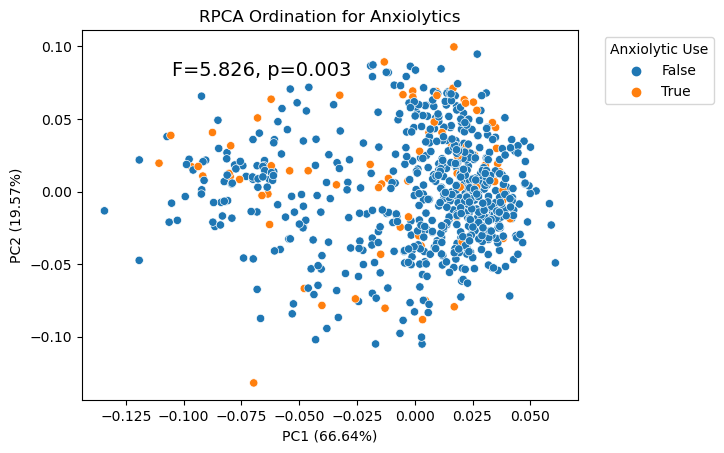

In [75]:
make_pcoa(data_dict_16s['ANX_OR_MDD'], metadata, 'N05B_Anxiolytics', xpos=-0.105, ypos=0.08, 
          title='RPCA Ordination for Anxiolytics', custom_title='Anxiolytic Use')

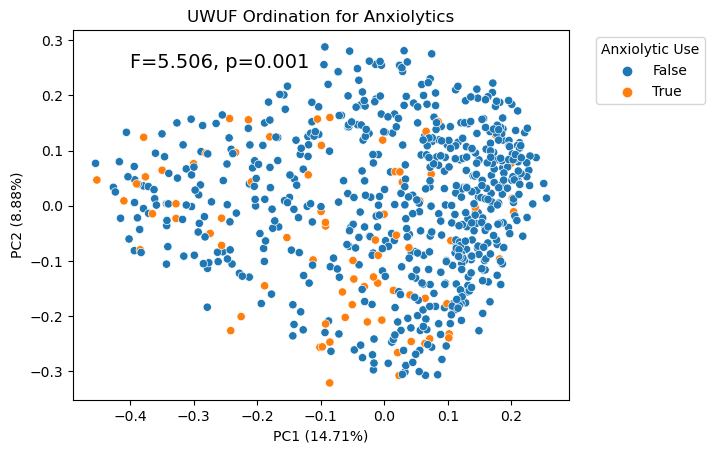

In [82]:
make_pcoa(data_dict_16s['ANX_OR_MDD'], metadata, 'N05B_Anxiolytics', xpos=-0.4, ypos=0.25, 
          title='UWUF Ordination for Anxiolytics', custom_title='Anxiolytic Use', distance_metric='uwuf')

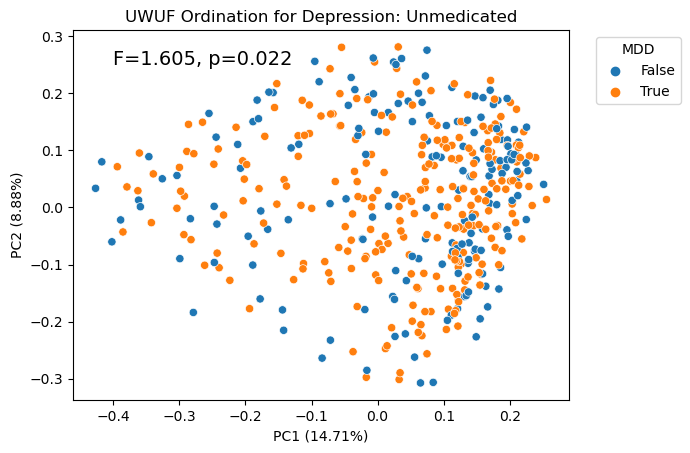

In [69]:
make_pcoa(data_dict_16s['Unmedicated'], metadata, 'DX_MDD', xpos=-0.4, ypos=0.25, 
          title='UWUF Ordination for Depression: Unmedicated', custom_title='MDD', distance_metric='uwuf')

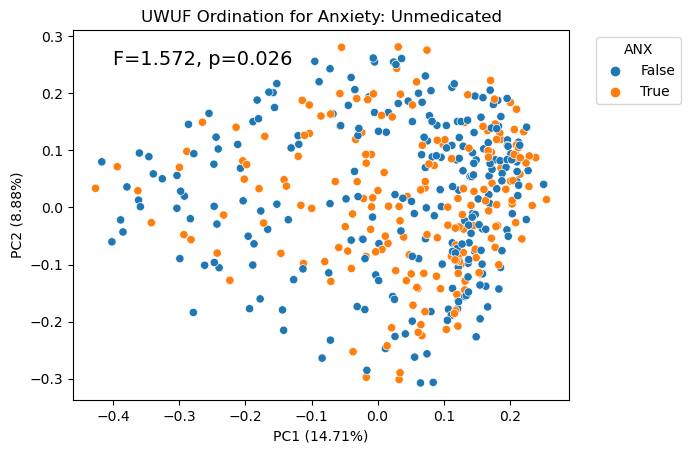

In [70]:
make_pcoa(data_dict_16s['Unmedicated'], metadata, 'DX_ANX', xpos=-0.4, ypos=0.25, 
          title='UWUF Ordination for Anxiety: Unmedicated', custom_title='ANX', distance_metric='uwuf')

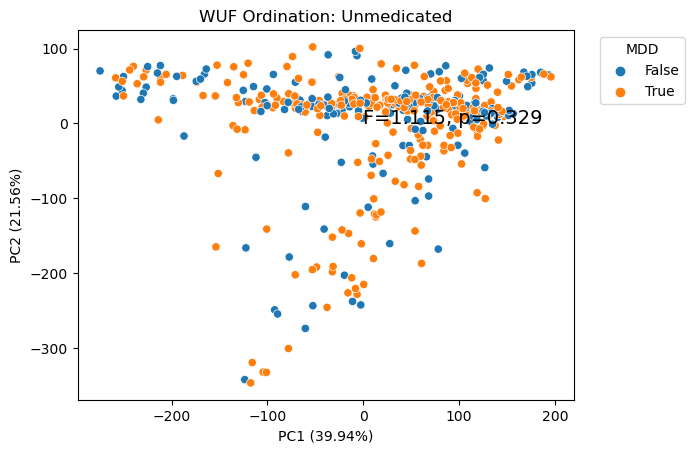

In [64]:
make_pcoa(data_dict_16s['Unmedicated'], metadata, 'DX_MDD', xpos=-0.4, ypos=0.25, 
          title='WUF Ordination: Unmedicated', custom_title='MDD', distance_metric='wuf')

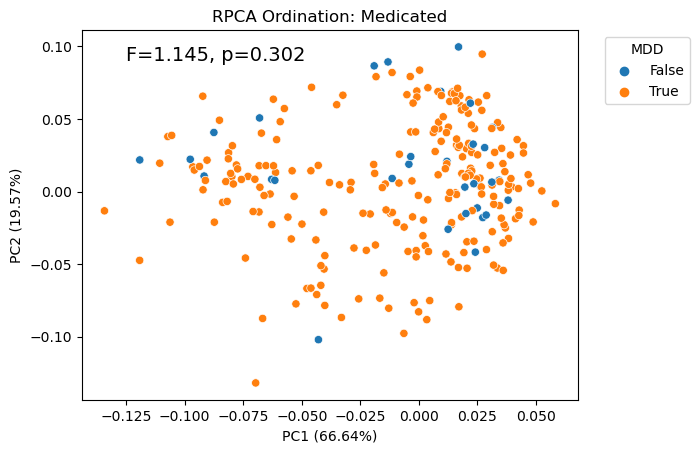

In [59]:
make_pcoa(data_dict_16s['Medicated'], metadata, 'DX_MDD', xpos=-0.125, ypos=0.09, 
          title='RPCA Ordination: Medicated', custom_title='MDD')

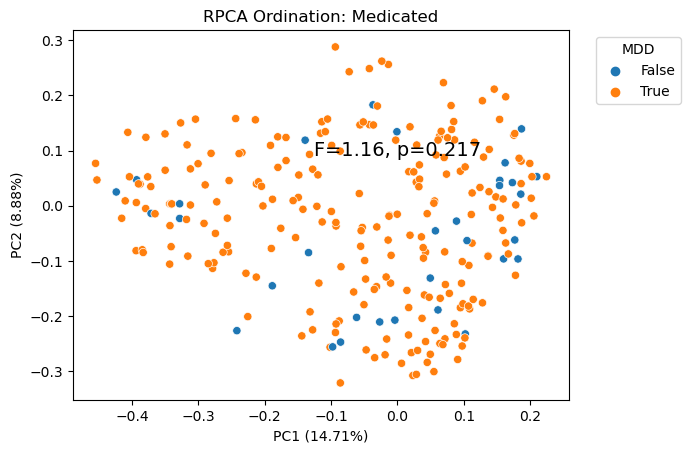

In [65]:
make_pcoa(data_dict_16s['Medicated'], metadata, 'DX_MDD', xpos=-0.125, ypos=0.09, 
          title='RPCA Ordination: Medicated', custom_title='MDD', distance_metric='uwuf')

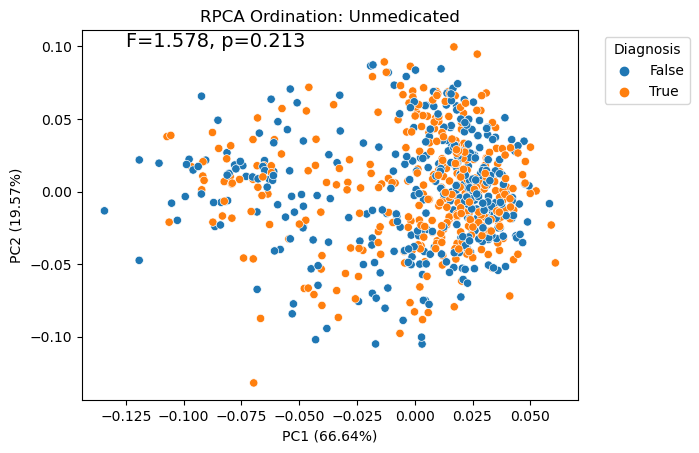

In [40]:
make_pcoa(data_dict_16s['Unmedicated'], metadata, 'DX_ANX', xpos=-0.125, ypos=0.1, 
          title='RPCA Ordination: Unmedicated')

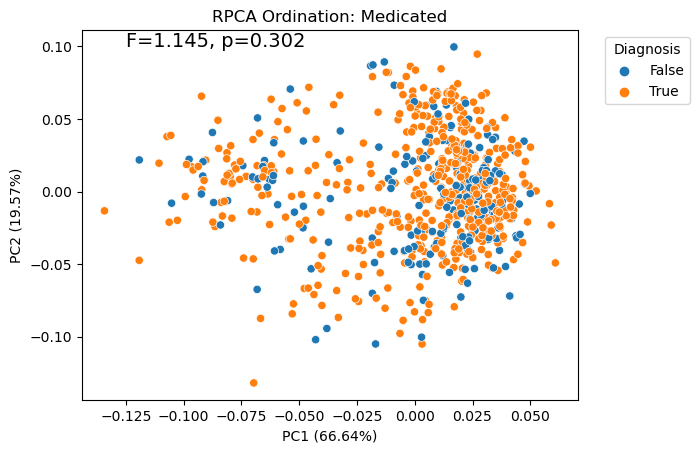

In [39]:
make_pcoa(data_dict_16s['Medicated'], metadata, 'DX_MDD', xpos=-0.125, ypos=0.1, 
          title='RPCA Ordination: Medicated')

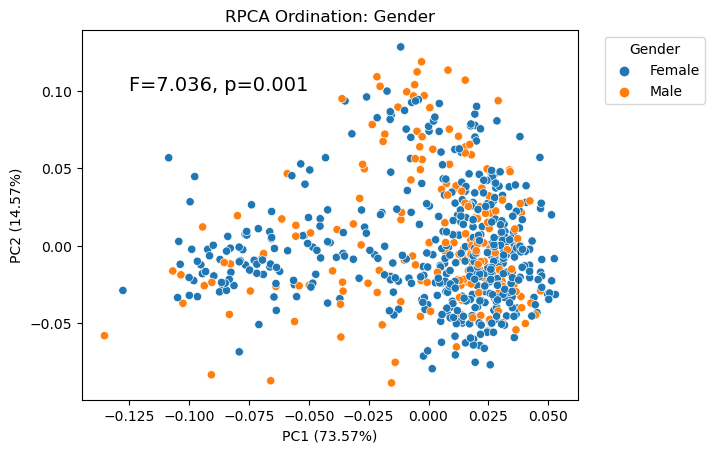

In [62]:
make_pcoa(data_dict_16s['ANX_OR_MDD'], metadata, 'Gender', xpos=-0.125, ypos=0.1, 
          title='RPCA Ordination: Gender', custom_title='Gender')

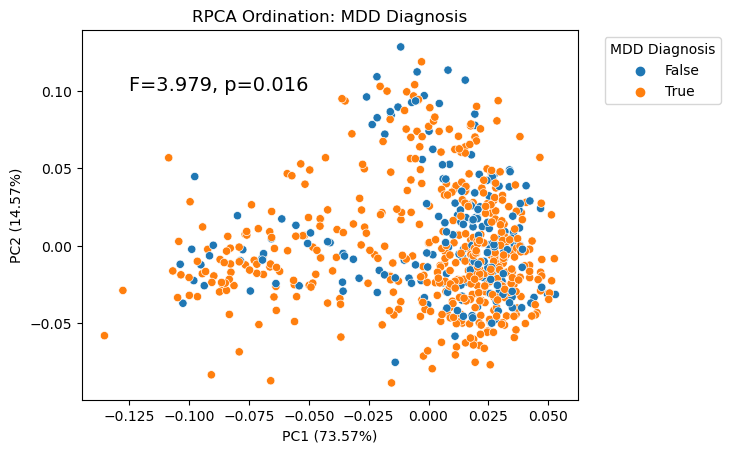

In [67]:
make_pcoa(data_dict_16s['ANX_OR_MDD'], metadata, 'DX_MDD', xpos=-0.125, ypos=0.1, 
          title='RPCA Ordination: MDD Diagnosis', custom_title='MDD Diagnosis')

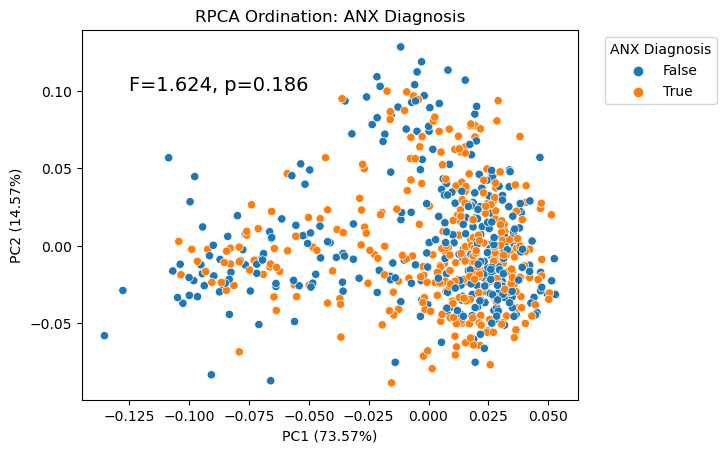

In [68]:
make_pcoa(data_dict_16s['ANX_OR_MDD'], metadata, 'DX_ANX', xpos=-0.125, ypos=0.1, 
          title='RPCA Ordination: ANX Diagnosis', custom_title='ANX Diagnosis')

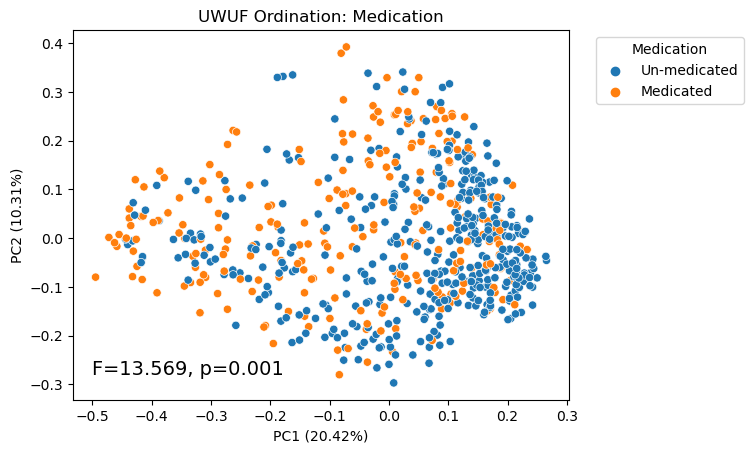

In [59]:
make_pcoa(data_dict_16s['ANX_OR_MDD'], metadata, 'Medicated', xpos=-0.5, ypos=-0.28, 
          title='UWUF Ordination: Medication', custom_title='Medication', distance_metric='uwuf')

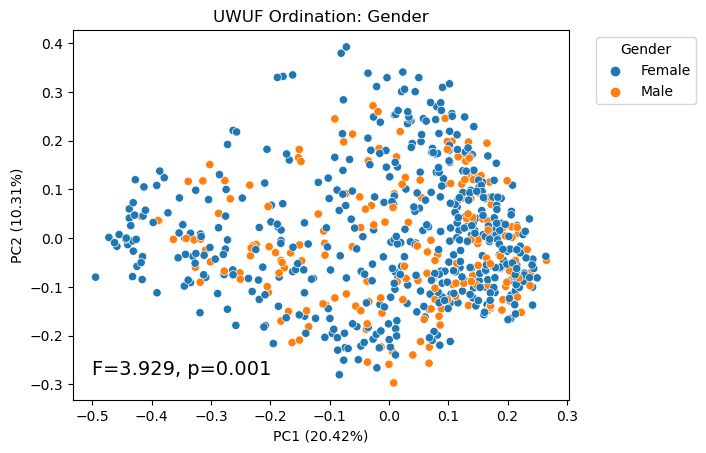

In [65]:
make_pcoa(data_dict_16s['ANX_OR_MDD'], metadata, 'Gender', xpos=-0.5, ypos=-0.28, 
          title='UWUF Ordination: Gender', custom_title='Gender', distance_metric='uwuf')

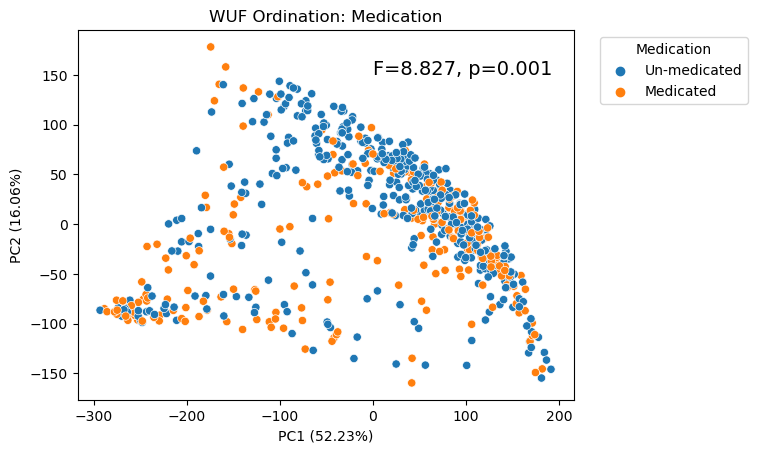

In [61]:
make_pcoa(data_dict_16s['ANX_OR_MDD'], metadata, 'Medicated', xpos=0, ypos=150, 
          title='WUF Ordination: Medication', custom_title='Medication', distance_metric='wuf')

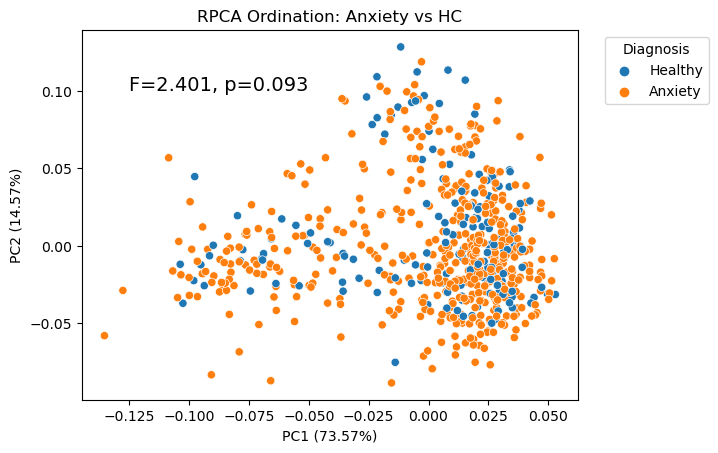

In [120]:
make_pcoa(data_dict_16s['ANX'], metadata, 'GroupAssignment', xpos=-0.125, ypos=0.1, 
          title='RPCA Ordination: Anxiety vs HC',  custom_labels=['Healthy', 'Anxiety'])

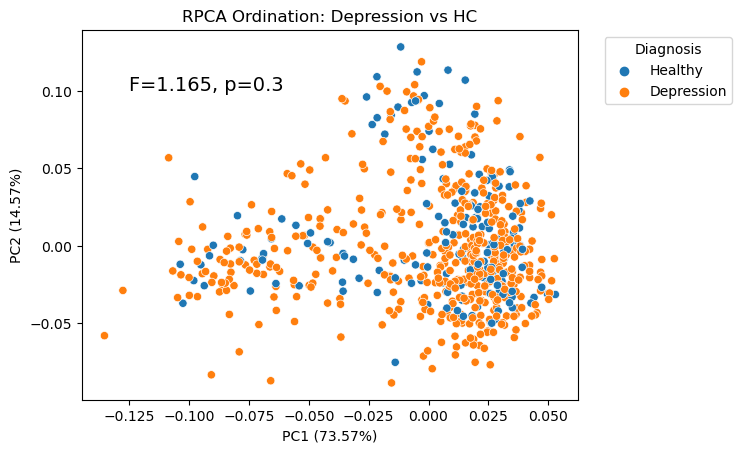

In [123]:
make_pcoa(data_dict_16s['ANX_ONLY'], metadata, 'GroupAssignment', xpos=-0.125, ypos=0.1, 
          title='RPCA Ordination: Depression vs HC', custom_labels=['Healthy', 'Depression'])

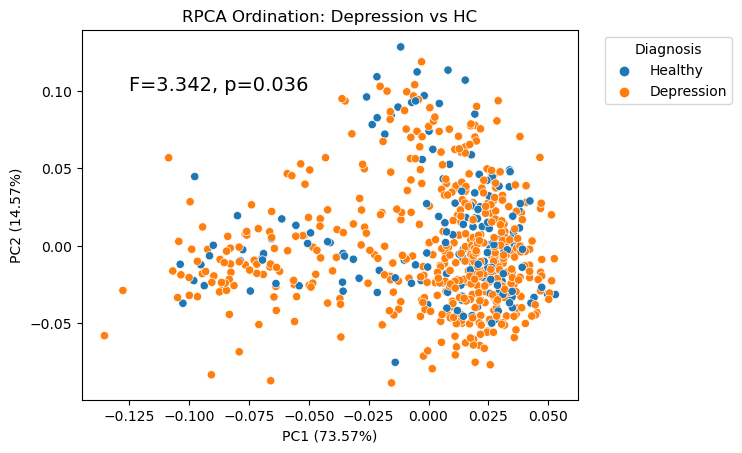

In [121]:
make_pcoa(data_dict_16s['MDD'], metadata, 'GroupAssignment', xpos=-0.125, ypos=0.1, 
          title='RPCA Ordination: Depression vs HC', custom_labels=['Healthy', 'Depression'])

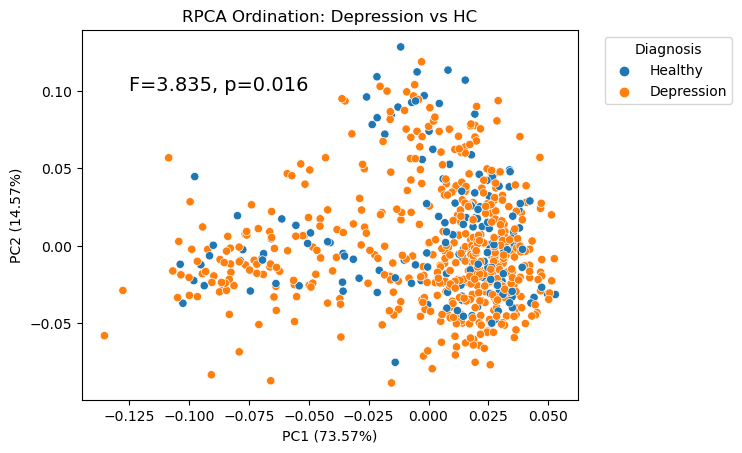

In [122]:
make_pcoa(data_dict_16s['MDD_ONLY'], metadata, 'GroupAssignment', xpos=-0.125, ypos=0.1, 
          title='RPCA Ordination: Depression vs HC', custom_labels=['Healthy', 'Depression'])

/Users/hazedil/opt/anaconda3/envs/qiime2-2022.11/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


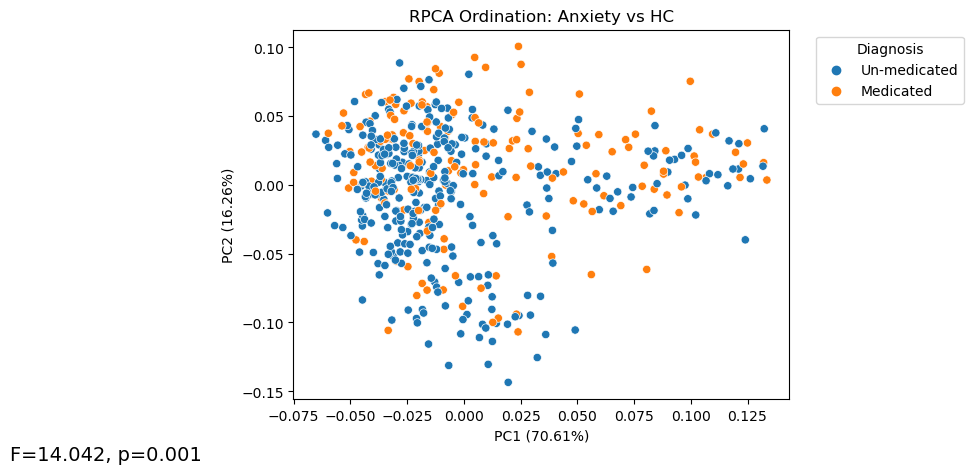

In [16]:
make_pcoa(data_dict_16s['ANX'], metadata, 'Medicated', xpos=-0.2, ypos=-0.2, 
          title='RPCA Ordination: Anxiety vs HC')

/Users/hazedil/opt/anaconda3/envs/qiime2-2022.11/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


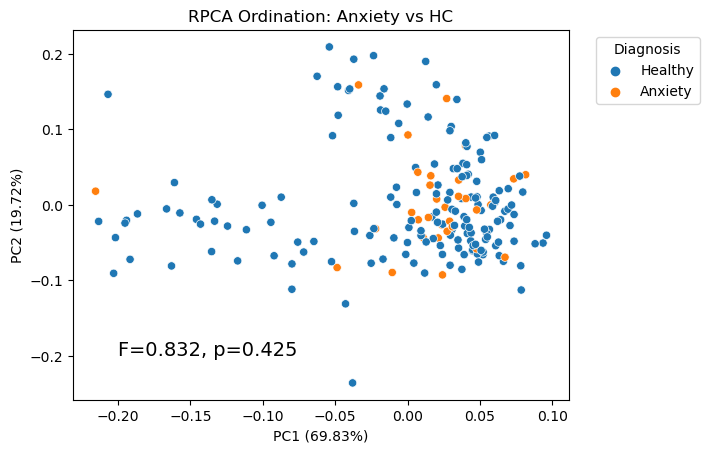

In [10]:
make_pcoa(data_dict_16s['ANX_ONLY'], metadata, 'GroupAssignment', xpos=-0.2, ypos=-0.2, 
          title='RPCA Ordination: Anxiety vs HC', custom_labels=['Healthy', 'Anxiety'])

/Users/hazedil/opt/anaconda3/envs/qiime2-2022.11/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


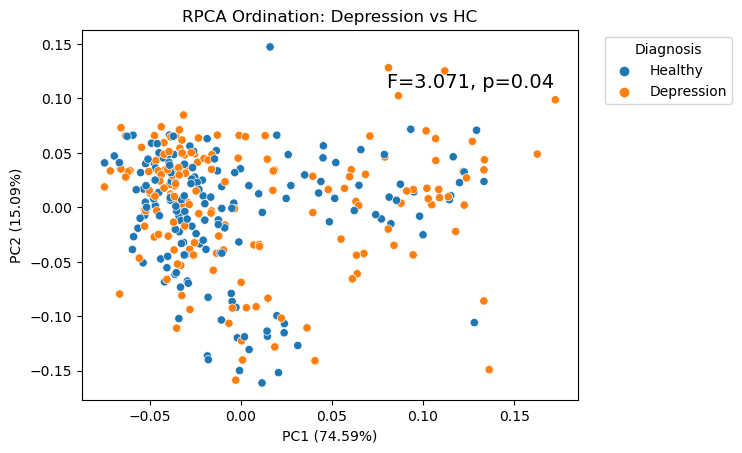

In [11]:
make_pcoa(data_dict_16s['MDD_ONLY'], metadata, 'GroupAssignment', xpos=0.08, ypos=0.11, 
          title='RPCA Ordination: Depression vs HC', custom_labels=['Healthy', 'Depression'])

/Users/hazedil/opt/anaconda3/envs/qiime2-2022.11/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


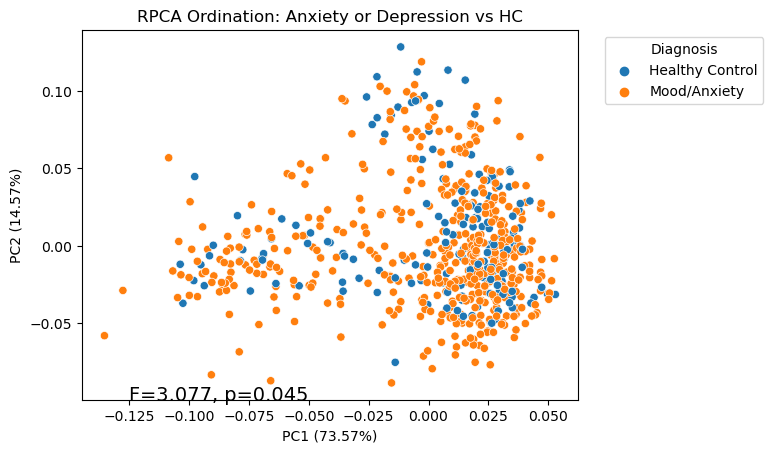

In [12]:
make_pcoa(data_dict_16s['ANX_OR_MDD'], metadata, 'GroupAssignment', xpos=-0.125, ypos=-.10, 
          title='RPCA Ordination: Anxiety or Depression vs HC')

/Users/hazedil/opt/anaconda3/envs/qiime2-2022.11/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


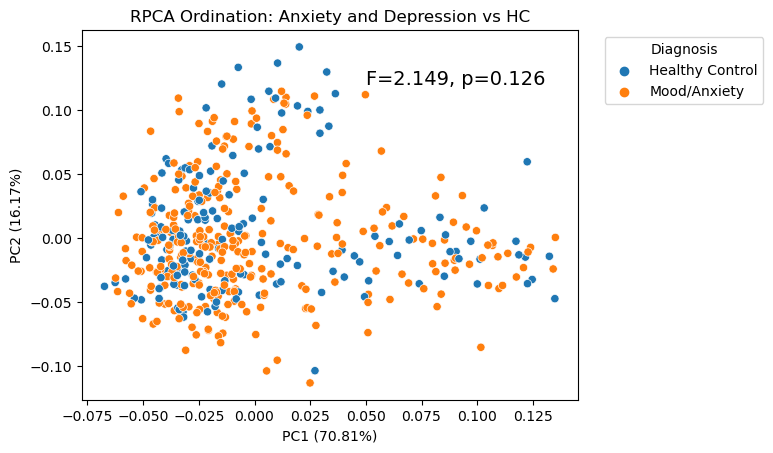

In [13]:
make_pcoa(data_dict_16s['ANX_AND_MDD'], metadata, 'GroupAssignment', xpos=0.05, ypos=0.12, 
          title='RPCA Ordination: Anxiety and Depression vs HC')

In [14]:
make_pcoa(data_dict_16s['ANX_MDD_COMP'], metadata, 'DX_MDD', xpos=-0.22, ypos=-.18, 
          title='RPCA Ordination: Anxiety vs Depression', custom_labels=['Anxiety', 'Depression'])

KeyError: 'ANX_MDD_COMP'

## 16S and Metagenomics

In [17]:
def get_group_permanova(bt, rarefaction_depth, metadata, tree, column='GroupAssignment'): 
    table = q2.Artifact.import_data('FeatureTable[Frequency]', bt)
    rarefied = feature_table.methods.rarefy(table=table, sampling_depth=rarefaction_depth).rarefied_table 
    dm = diversity.pipelines.beta_phylogenetic(table, tree, 'unweighted_unifrac').distance_matrix
    return skbio.stats.distance.permanova(dm.view(skbio.DistanceMatrix), metadata.to_dataframe(), 
                                          'GroupAssignment')

In [19]:
tables = []
metrics = []
pseudo_f = []
p_values = []

for k in tables_needed.keys(): 
    if k == 'Nightingale':
        continue 
    elif '16S' in k: 
        depth = 5000
    else: 
        depth = 500000
    perm_res = get_group_permanova(tables_needed[k], depth, metadata, gg2_tree)
    tables.append(k)
    metrics.append('unweighted unifrac')
    pseudo_f.append(perm_res['test statistic'])
    p_values.append(perm_res['p-value'])
res_df = pd.DataFrame(data={'table_name': tables, 'metric': metrics, 'pseudo_f': pseudo_f, 'p_value': p_values})

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/a9ffca3a-700b-4e01-b8a5-3ef702a0cc72/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk -m unweighted -o /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-dfvwejh6

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command:

ssu -i /var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/637a02b8-2fe4-4f55-9e42-207b2d2d1834/data/feature-table.biom -t /var/folders/67/8j7qqb5s0cv4wfqrkcwnz988000

Compute failed in one_off: Table observation IDs are not a subset of the tree tips. This error can also be triggered if a node name contains a single quote (this is unlikely).


CalledProcessError: Command '['ssu', '-i', '/var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/4bdec5ff-093f-4a3f-8b64-05aff4d92758/data/feature-table.biom', '-t', '/var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/qiime2/hazedil/data/1d6fd745-9191-448c-9066-6b754e53a272/data/tree.nwk', '-m', 'unweighted', '-o', '/var/folders/67/8j7qqb5s0cv4wfqrkcwnz9880000gn/T/q2-LSMatFormat-f41df7kf']' returned non-zero exit status 1.